# Data Compression using Autoencoders

Some resources taken from [here](https://github.com/Skelpdar/HEPAutoencoders)


In [101]:
# mounting google drive 
from google.colab import drive
drive.mount('/gdrive')
! pip install -q corner

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
import seaborn as sns
import pylab as pl
from corner import corner

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import fastai
from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
from fastai import train as tr

import os
import time
device = torch.device('cuda')

In [103]:
#getting data from drive
path = '/gdrive/My Drive/Machine_learning/GSOC_Evaluation_Datasets/'
os.listdir(path)

['all_jets_test_4D_100_percent.pkl', 'all_jets_train_4D_100_percent.pkl']

In [104]:
# reading the data from pickle files
df = pd.read_pickle(f'{path}all_jets_train_4D_100_percent.pkl')
print(df.shape)
df.head()

(111778, 4)


,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


In [105]:
df_test = pd.read_pickle(f'{path}all_jets_test_4D_100_percent.pkl')
print(df_test.shape)
df_test.head()

(27945, 4)


,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


# EDA and Preprocessing

In [106]:
# checking for null values
print(f'NaNs in train: {df.isnull().sum().sum()}')
print(f'NaNs in test: {df_test.isnull().sum().sum()}')

NaNs in train: 0
NaNs in test: 0


In [107]:
# understanding the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
m,111778.0,8941.356799,7421.270111,-0.045353,4658.248535,5728.732910,10467.514160,128247.671875
pt,111778.0,64458.683471,69874.993026,20000.154297,22514.718750,27141.585938,78976.080078,748795.937500
phi,111778.0,0.001691,1.803151,-3.141587,-1.558285,0.019362,1.553306,3.141546
eta,111778.0,0.043500,1.448439,-4.745398,-1.139831,0.086258,1.178913,4.747644


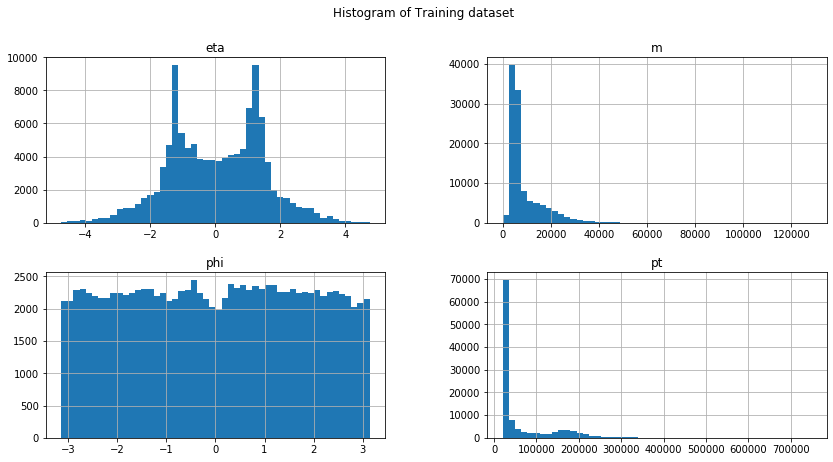

In [108]:
# checking data distribution
df.hist(figsize=(14,7), bins=50)
pl.suptitle("Histogram of Training dataset")
plt.show()

In [109]:
# checking skweness values
df.skew()

m      2.420373
pt     1.958352
phi   -0.009165
eta   -0.062186
dtype: float64

Some skewness in **m** and **pt** features

In [110]:
# custom normalization function for each feature
def normalize(df):
  df_temp = pd.DataFrame()
  df_temp['phi'] = df['phi'] / 3.0
  df_temp['eta'] = df['eta'] / 4.0
  df_temp['m'] = np.log10(df['m']+1)
  df_temp['pt'] = np.log10(df['pt'])
  return df_temp

def inverse_norm(df_norm):
  df_temp = pd.DataFrame()
  df_temp['phi'] = df_norm['phi'] * 3.0
  df_temp['eta'] = df_norm['eta'] * 4.0
  df_temp['m'] = (10**df_norm['m'])-1
  df_temp['pt'] = 10**df_norm['pt']
  return df_temp

df_norm = normalize(df)
df_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
phi,111778.0,0.000564,0.601050,-1.047196,-0.519428,0.006454,0.517769,1.047182
eta,111778.0,0.010875,0.362110,-1.186349,-0.284958,0.021565,0.294728,1.186911
m,111778.0,3.832283,0.399387,-0.020157,3.668316,3.758134,4.019885,5.108053
pt,111778.0,4.627400,0.363469,4.301033,4.352467,4.433635,4.897496,5.874363


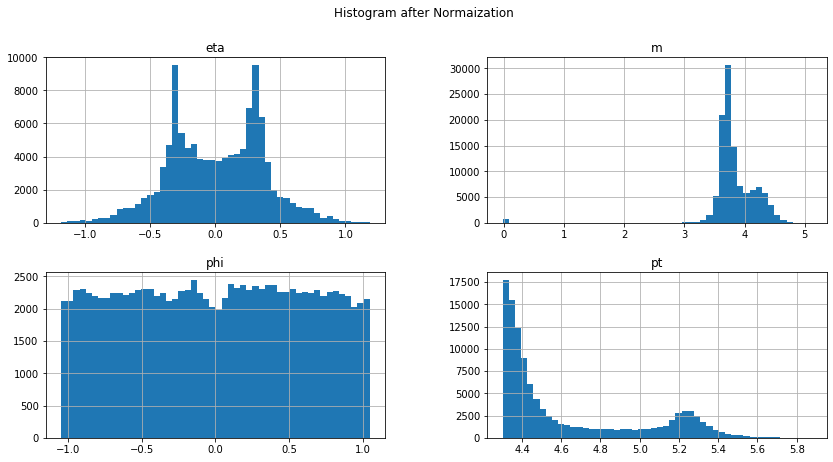

In [111]:
# checking normalized distribution
df_norm.hist(figsize=(14,7), bins=50)
pl.suptitle("Histogram after Normaization")
plt.show()

In [112]:
# normalizing test set
df_test_norm = normalize(df_test)
X = df_norm.values
X_test = df_test_norm.values
X, X_test = X.astype('float32'), X_test.astype('float32')
print(X.shape, X_test.shape)

(111778, 4) (27945, 4)


In [113]:
df_test_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
phi,27945.0,0.002341,0.604655,-1.047164,-0.522089,0.009406,0.523748,1.047176
eta,27945.0,0.010087,0.359800,-1.195702,-0.283597,0.017665,0.294177,1.164686
m,27945.0,3.832826,0.398385,-0.020140,3.668740,3.756826,4.021726,5.058936
pt,27945.0,4.628560,0.365982,4.301032,4.352060,4.433799,4.902812,5.895504


The distribution of **test set** is very similar to the **train set**

In [0]:
# preparing pytorch dataset
train_ds = TensorDataset(torch.tensor(X), torch.tensor(X))
valid_ds = TensorDataset(torch.tensor(X_test), torch.tensor(X_test))

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1204)
db = basic_data.DataBunch(train_dl, valid_dl)

# Building the Model

In [0]:
# defining model architecture
class autoencoder(nn.Module):
    def __init__(self, n_features=4):
        super().__init__()
        lrelu = nn.LeakyReLU(negative_slope=0.05)
        self.encoder = nn.Sequential(nn.Linear(n_features, 200),
                                     lrelu,
                                     nn.Linear(200, 100),
                                     lrelu,
                                     nn.Linear(100, 50),
                                     lrelu,
                                     nn.Linear(50, 3))
        self.decoder = nn.Sequential(lrelu,
                                     nn.Linear(3, 50),
                                     lrelu,
                                     nn.Linear(50, 100),
                                     lrelu,
                                     nn.Linear(100, 200),
                                     lrelu,
                                     nn.Linear(200, n_features))

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def describe(self):
        return 'autoencoder(200-100-50-3-50-100-200)'

In [0]:
# compiling the model
model = autoencoder()
learn = basic_train.Learner(data=db,
                            model=model,
                            loss_func=nn.MSELoss(),
                            wd=1e-6,
                            callback_fns=ActivationStats,
                            bn_wd=False,
                            true_wd=True)

# Model Training

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


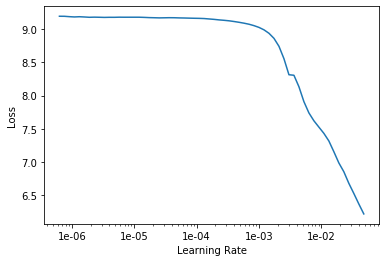

In [118]:
# finding a good learning rate to train on
tr.lr_find(learn)
learn.recorder.plot()

**1e-03** seems to be a good learning rate to train on

In [119]:
# starting with a small learning rate
lr, wd = 1e-6, 1e-06
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,9.177856,9.175708,00:02
1,9.162132,9.160122,00:02
2,9.152758,9.144371,00:02
3,9.130725,9.128798,00:02
4,9.113931,9.113110,00:02
5,9.100271,9.097108,00:02
6,9.087027,9.080913,00:02
7,9.068516,9.064905,00:02
8,9.051743,9.048912,00:02
9,9.034810,9.032693,00:02


In [120]:
# training on optimal learning rate
lr, wd = 1e-3, 1e-04
learn.fit(200, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.513129,0.141999,00:02
1,0.190042,0.141424,00:02
2,0.147539,0.140177,00:02
3,0.140052,0.138653,00:02
4,0.137226,0.137035,00:02
5,0.134224,0.131547,00:02
6,0.127041,0.121961,00:02
7,0.060804,0.036874,00:02
8,0.040267,0.036001,00:02
9,0.036280,0.036251,00:02


In [121]:
lr, wd = 1e-04, 1e-04
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.001233,0.001237,00:02
1,0.001226,0.001231,00:02
2,0.001220,0.001231,00:02
3,0.001230,0.001243,00:02
4,0.001218,0.001230,00:02
5,0.001221,0.001244,00:02
6,0.001217,0.001238,00:02
7,0.001219,0.001233,00:02
8,0.001225,0.001232,00:02
9,0.001221,0.001237,00:02


In [122]:
lr, wd = 1e-05, 1e-04
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.001178,0.001195,00:02
1,0.001175,0.001197,00:02
2,0.001167,0.001196,00:02
3,0.001168,0.001198,00:02
4,0.001166,0.001196,00:02
5,0.001172,0.001197,00:02
6,0.001173,0.001194,00:02
7,0.001163,0.001195,00:02
8,0.001171,0.001194,00:02
9,0.001167,0.001194,00:02


In [123]:
lr, wd = 1e-06, 1e-04
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.001158,0.001193,00:02
1,0.001159,0.001193,00:02
2,0.001164,0.001193,00:02
3,0.001165,0.001193,00:02
4,0.001165,0.001193,00:02
5,0.001163,0.001192,00:02
6,0.001162,0.001193,00:02
7,0.001163,0.001193,00:02
8,0.001155,0.001192,00:02
9,0.001155,0.001193,00:02


In [0]:
# saving model
torch.save(model.state_dict(), 'model')

# Analysing Results

In [124]:
# getting predictions on test set
test_value = torch.tensor(X_test)
test_value = test_value.to(device)
start = time.time()
pred = model(test_value).detach().cpu().numpy()
print(f'Inference Time: {(time.time() - start)*1000:.2f}ms')
print(f'Final MSE: {mean_squared_error(X_test, pred)}')

Inference Time: 3.11ms
Final MSE: 0.0011921771802008152


**The average inference time is 2.45 ms for around 28,000 values**


In [0]:
# rescaling to original values
pred = pd.DataFrame(pred, columns=['phi', 'eta', 'm', 'pt'])
pred = inverse_norm(pred)
pred = pred[df_test.columns]
pred = pred.values
X_test = df_test.values

In [126]:
# MSE for each feature
for i in range(4):
  print(f'MSE on {df.columns[i]}: {mean_squared_error(X_test[:,i], pred[:,i])}')

MSE on m: 2618135.032821287
MSE on pt: 264963443.2394437
MSE on phi: 7.484926159334204e-05
MSE on eta: 0.0062322280722480455


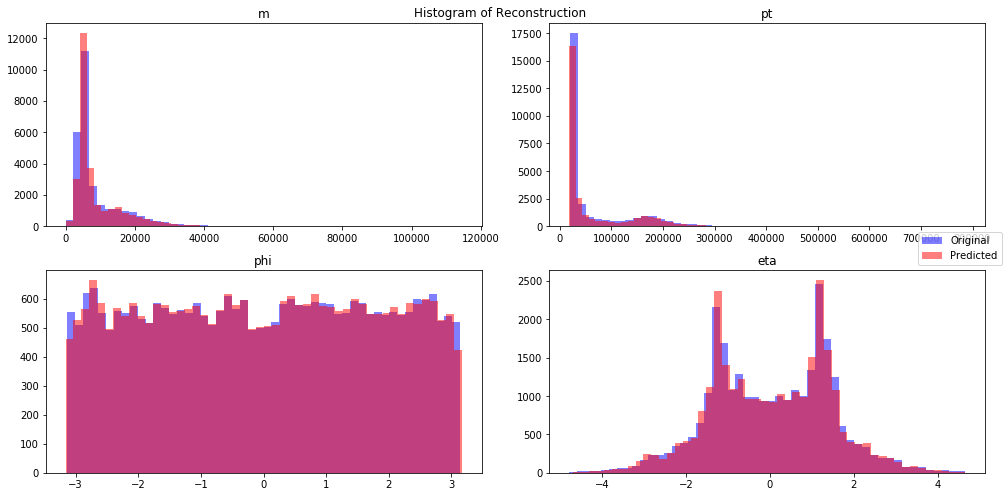

In [127]:
# comparing histograms
fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0][0].hist(X_test[:,0], bins=50, fc=(0,0,1,0.5), label='Original')
ax[0][0].hist(pred[:,0], bins=50, fc=(1,0,0,0.5), label='Predicted')
ax[0][0].set_title(f'{df.columns[0]}')

ax[0][1].hist(X_test[:,1], bins=50, fc=(0,0,1,0.5), label='Original')
ax[0][1].hist(pred[:,1], bins=50, fc=(1,0,0,0.5), label='Predicted')
ax[0][1].set_title(f'{df.columns[1]}')

ax[1][0].hist(X_test[:,2], bins=50, fc=(0,0,1,0.5), label='Original')
ax[1][0].hist(pred[:,2], bins=50, fc=(1,0,0,0.5), label='Predicted')
ax[1][0].set_title(f'{df.columns[2]}')

ax[1][1].hist(X_test[:,3], bins=50, fc=(0,0,1,0.5), label='Original')
ax[1][1].hist(pred[:,3], bins=50, fc=(1,0,0,0.5), label='Predicted')
ax[1][1].set_title(f'{df.columns[3]}')


handles, labels = ax[1][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')
fig.suptitle('Histogram of Reconstruction')
fig.tight_layout()
plt.savefig('reconstruction_hist.png')
plt.show()

**The reconstructed values are able to cover most of the original values perfectly in all features**

In [129]:
# getting the residuals
residual = (pred - X_test)
print(f'Min: {residual.min(axis=0)}\nMax: {residual.max(axis=0)}')

Min: [-1.384200e+04 -3.179824e+05 -2.215981e-01 -1.353147e+00]
Max: [1.649937e+04 9.910847e+04 2.932921e-01 1.696106e+00]


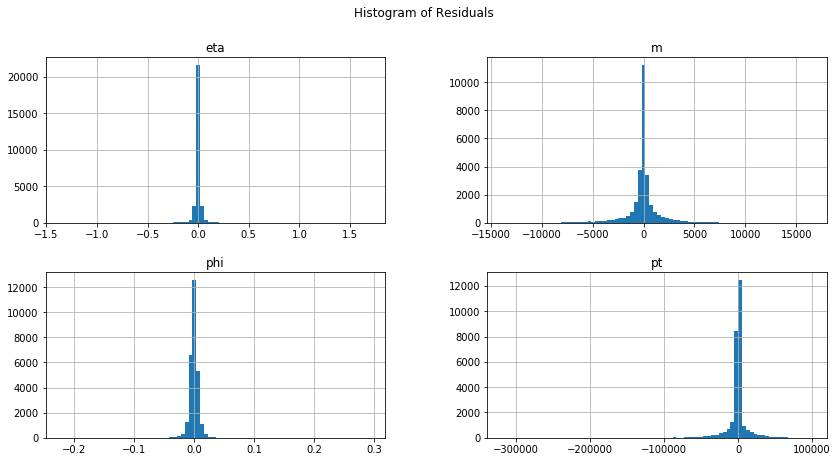

In [130]:
# plotting the residuals
df_residual = pd.DataFrame(residual, columns=df.columns)
df_residual.hist(figsize=(14,7), bins=80)
pl.suptitle("Histogram of Residuals")
plt.savefig("residual_hist.png")
plt.show()

**Most of the residual values are close to zero**

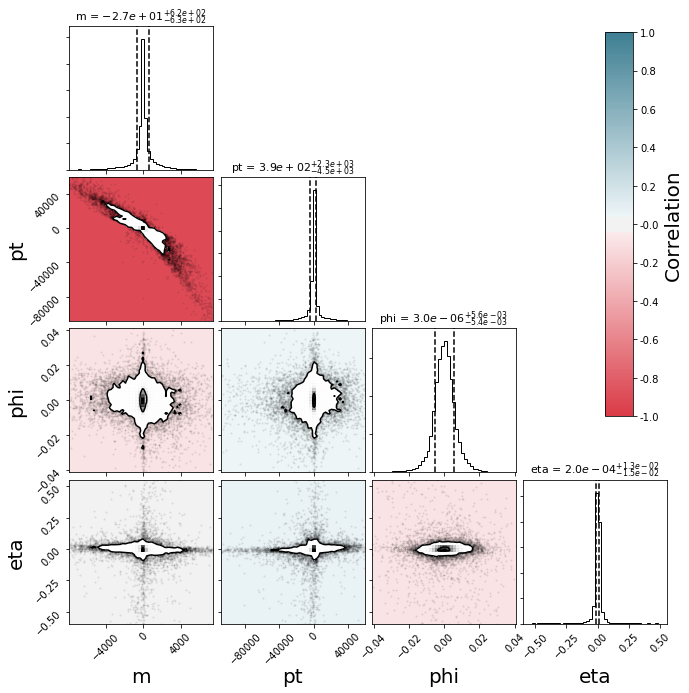

In [131]:
# correlation between residuals
cmap = sns.diverging_palette(10, 220, as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
group = df_residual.columns.values
corr = df_residual.corr()
qs = np.quantile(residual, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(residual, range=ranges, plot_density=True,
                plot_contours=True, no_fill_contours=False, bins=50,
                labels=group, label_kwargs={'fontsize': 20},
                show_titles=True, title_kwargs={'fontsize': 11},
                quantiles=(0.16, 0.84), levels=(1 - np.exp(-0.5), .90),
                fill_contours=False, title_fmt='.1e')

axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f',
                    ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)
plt.savefig('correlation.png')
plt.show()

# Observations

* The features present in the data had very different ranges and were also skewed, due to which:
  1. It was difficult to rescale the data
  2. It was difficult for the autoencoder to capture the information at the ends.
* I tried various rescaling techniques, but custom scaling functions for each feature gave the best performance.
* I decided to use the architecture presented in the [thesis](https://lup.lub.lu.se/student-papers/search/publication/9004751) but increasing the nodes and layers improved the MSE scores.
* The distribution of train and test sets were quite similar which made the validation loss similar to the training loss